# Simple LNG Market

The importing countries try to minimize their costs for the imported LNG. The object of this model is to minimize total LNG costs while satisfying constraints on the supplies available at each of the exporting nodes, and satisfying demand requirements at each of the importing nodes.

In [2]:
import shutil
import sys
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

from IPython.display import display
from geopy.geocoders import Nominatim
from geopy import distance
from pyomo.environ import *

geolocator = Nominatim(user_agent="Your_Name")
pd.set_option('precision', 3)
MMBtu = 23.161 #1m³LNG = 23.161MMBtu 

## 1 Data 

### 1.1 Importing Nodes

Ten largest importing countries according to "BP Stats Review (2020)" are taken into consideration.

In [3]:
# Data for importing and exporting countries from "BP Stats Review (2020)"

# "Import (MMBtu)" column consists of imports in m³ multiplied with conversion factor

Imp_Countries = pd.DataFrame({
    
    "Country" : ["Japan", "China", "South Korea", "India", "France", "Spain",
                 "UK", "Italy", "Turkey", "Belgium"],
    
     "Import (MMBtu)" : [105.5*10**9 * MMBtu, 84.8*10**9 * MMBtu, 55.6*10**9 * MMBtu, 32.9*10**9 * MMBtu,
                       22.9*10**9 * MMBtu, 21.9*10**9 * MMBtu, 18*10**9 * MMBtu, 13.5*10**9 * MMBtu,
                       12.9*10**9 * MMBtu, 7.2*10**9 * MMBtu],
    
    "Regasification Terminal" : ["Sodegaura", "Yancheng", "Incheon", "Dahej", "Dunkirk",
                     "Barcelona", "Isle of Grain", "Rovigo", "Marmara", "Zeebrugge"]
})

#Imp_Countries["Import (MMBtu)"] = (Imp_Countries["Import (MMBtu)"].astype(float)/1000000000).astype(str)


# getting the coordinates of largest regas terminals, not neccesarry anymore, since there is no suitable package
# for calculating sea distances :(

Imp_Countries["Location"] = Imp_Countries["Regasification Terminal"].apply(geolocator.geocode)
Imp_Countries["Point"]= Imp_Countries["Location"].apply(lambda loc: tuple(loc.point) if loc else None)
Imp_Countries[["Latitude", "Longitude", "Altitude"]] = pd.DataFrame(Imp_Countries["Point"].to_list(), index=Imp_Countries.index)

del Imp_Countries["Altitude"]
del Imp_Countries["Location"]
del Imp_Countries["Point"]


#center the columns, display() method doesn't work anymore, so not necessary for now
def pd_centered(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}])

#display(pd_centered(Imp_Countries))
Imp_Countries

,Country,Import (MMBtu),Regasification Terminal,Latitude,Longitude
0,Japan,2.443e+12,Sodegaura,35.430,139.954
1,China,1.964e+12,Yancheng,33.350,120.158
2,South Korea,1.288e+12,Incheon,37.456,126.705
3,India,7.620e+11,Dahej,21.712,72.590
4,France,5.304e+11,Dunkirk,51.035,2.377
5,Spain,5.072e+11,Barcelona,41.383,2.177
6,UK,4.169e+11,Isle of Grain,51.454,0.695
7,Italy,3.127e+11,Rovigo,44.977,12.274
8,Turkey,2.988e+11,Marmara,40.972,28.669
9,Belgium,1.668e+11,Zeebrugge,51.334,3.195


### 1.2 Exporting Nodes

Ten largest exporting countries according to "BP Stats Review (2020)" are taken into consideration.

In [4]:
# define DF with data for exporting countries (BP 2020)

Exp_Countries = pd.DataFrame({
    
    "Country" : ["Qatar", "Australia", "USA", "Russia", "Malaysia", "Nigeria",
                 "Trinidad & Tobago", "Algeria", "Indonesia","Oman"],
    
    "Export (MMBtu)" : [107.1*10**9 * MMBtu, 104.7*10**9 * MMBtu, 47.5*10**9 * MMBtu, 39.4*10**9 * MMBtu,
                        35.1*10**9 * MMBtu, 28.8*10**9 * MMBtu, 17.0*10**9 * MMBtu, 16.9*10**9 * MMBtu,
                        16.5*10**9 * MMBtu, 14.1*10**9 * MMBtu],
    
    "Break Eeven Price ($/MMBtu)" : [2.5, 6.5, 6.0, 4.5, 6.0, 4.08, 5.1, 2.5, 6.0, 3.5],
    
    #"Feedstock ($/MMBtu)" : [0.5, 3.0, 3.0, 0.5, 3.0, 2.2, 3.0, 0.5, 2.0, 1.5],

    #"Liquefaction ($/MMBtu)" : [2.0, 3.5, 3.0, 4.0, 3.0, 1.88, 2.1, 2.0, 4.0, 2.0],
    
    "Liquefaction Terminal" : ["Ras Laffan", "Gladstone", "Sabine Pass", "Sabetta",
                               "Bintulu", "Bonny Island", "Point Fortin",
                               " Bethioua", "Bontang", "Qalhat"],
})

#Exp_Countries["Export (Bcm)"] = (Exp_Countries["Export (Bcm)"].astype(float)/1000000000).astype(str)


# Getting the coordinates of liquefaction terminals, not neccesarry anymore, since there is no suitable package
# for calculating sea distances :(

Exp_Countries["Location"] = Exp_Countries["Liquefaction Terminal"].apply(geolocator.geocode)
Exp_Countries["Point"] = Exp_Countries["Location"].apply(lambda loc: tuple(loc.point) if loc else None)
Exp_Countries[["Latitude", "Longitude", "Altitude"]] = pd.DataFrame(Exp_Countries["Point"].to_list(), index=Exp_Countries.index)

# remove unnecessary columns
del Exp_Countries["Altitude"]
del Exp_Countries["Location"]
del Exp_Countries["Point"]

#display(pd_centered(Exp_Countries))
Exp_Countries

,Country,Export (MMBtu),Break Eeven Price ($/MMBtu),Liquefaction Terminal,Latitude,Longitude
0,Qatar,2.481e+12,2.50,Ras Laffan,25.898,51.533
1,Australia,2.425e+12,6.50,Gladstone,-23.843,151.256
2,USA,1.100e+12,6.00,Sabine Pass,29.733,-93.896
3,Russia,9.125e+11,4.50,Sabetta,71.236,72.127
4,Malaysia,8.130e+11,6.00,Bintulu,3.187,113.047
5,Nigeria,6.670e+11,4.08,Bonny Island,4.456,7.243
6,Trinidad & Tobago,3.937e+11,5.10,Point Fortin,10.174,-61.672
7,Algeria,3.914e+11,2.50,Bethioua,35.806,-0.268
8,Indonesia,3.822e+11,6.00,Bontang,0.124,117.472
9,Oman,3.266e+11,3.50,Qalhat,34.358,35.783


### 1.3 Sea distances among the importing and exporting nodes

In [5]:
# Define DF with distances among largest liquefaction and regas terminals in nautical miles
# In case of lack of route to the specific terminal, next largest port was taken
# sea-distances.org, searoutes.com

# if route over canal: distance rounded on 0 for suez and on 5 for panama, needed for later calculations

Distances = pd.DataFrame([(6512, 5846, 6161, 1301, 6240, 4650, 6260, 4380, 3460, 6270),
                          
                          (3861, 4134, 4313, 5918, 11650, 10060, 11670, 9790, 8870, 11680),
                          
                          (9205, 10075, 10005, 9645, 4881, 5206, 4897, 6354, 6341, 4908),
                          
                          (4929, 5596, 5671, 10160, 2494, 4252, 2511, 5546, 5481, 2477),
                          
                          (2276, 1656, 1998, 3231, 8980, 7390, 9000, 7120, 6200, 9010),
                          
                          (10752, 10088, 10406, 6988, 4287, 3824, 4309, 4973, 4961, 4321),
                          
                          (8885, 9755, 9665, 8370, 3952, 3926, 3974, 5074, 5062, 3984),
                          
                          (9590, 8930, 9240, 4720, 1519, 343, 1541, 1432, 1417, 1552),
                          
                          (2651, 2181, 2487, 3517, 9260, 7670, 9280, 7390, 6470, 9290),
                          
                          (6046, 5379, 5694, 853, 5760, 4180, 5790, 3900, 2980, 5800)

                         ],

                  index=["Qatar", "Australia", "USA", "Russia", "Malaysia", 
                         "Nigeria", "Trinidad & Tobago", "Algeria", "Indonesia"
                         ,"Oman"],

                  columns = ("Japan", "China", "South Korea", "India", "France",
                             "Spain", "UK", "Italy", "Turkey", "Belgium"))

#display(pd_centered(Distances))
Distances

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,6512,5846,6161,1301,6240,4650,6260,4380,3460,6270
Australia,3861,4134,4313,5918,11650,10060,11670,9790,8870,11680
USA,9205,10075,10005,9645,4881,5206,4897,6354,6341,4908
Russia,4929,5596,5671,10160,2494,4252,2511,5546,5481,2477
Malaysia,2276,1656,1998,3231,8980,7390,9000,7120,6200,9010
Nigeria,10752,10088,10406,6988,4287,3824,4309,4973,4961,4321
Trinidad & Tobago,8885,9755,9665,8370,3952,3926,3974,5074,5062,3984
Algeria,9590,8930,9240,4720,1519,343,1541,1432,1417,1552
Indonesia,2651,2181,2487,3517,9260,7670,9280,7390,6470,9290
Oman,6046,5379,5694,853,5760,4180,5790,3900,2980,5800


### 1.4 LNG Carrier

To keep the model simple it is assumed that there is only one type of the LNG carrier with the following characteristics:

In [6]:
# define DF with lng carrier properties

LNG_Carrier = pd.DataFrame({"Capacity (m³)" : [160000], # average capacity in 2019 160000 (!!! https://www.rivieramm.com/opinion/opinion/lng-shipping-by-numbers-36027)
                            "Spot Charter Rate ($/day)" : [70000], # average spot charter rate in 2019
                            "Speed (knots/h)" : [17],
                            "Bunker (mt/d)" : [110], # !!! Does boil off reduce it and what's the ratio then??? 
                            "Bunkers Price ($/mt)" : [670], 
                            "Boil off" : [1/1000], # the daily guaranteed maximum boil-off or DGMB (0,1%)
                            "Heel" : [4/100]}) # 4% of the cargo is retained as the heel (LNG storage tanks need to be kept cool)

#print(LNG_Carrier_DF.loc[0, "Capacity (m³)"])
#display(pd_centered(LNG_Carrier))
LNG_Carrier

,Capacity (m³),Spot Charter Rate ($/day),Speed (knots/h),Bunker (mt/d),Bunkers Price ($/mt),Boil off,Heel
0,160000,70000,17,110,670,0.001,0.04


### 1.5 Additional Costs

- Port costs for 3 days: outbound port, destination port and one day in case it has to wait for loading/unloading
- Canal Fees (Suez or Panama Canal)
- Agents and broker fees: 2% of charter cost plus
- Insurance: 2,600 $/day

In [7]:
# define DF containing additional costs

Additional_Costs = pd.DataFrame({
    "Port Costs ($ for 3 days)" : [300000], 
    "Suez Canal Costs ($/Cargo)" : [1000000],  # 0.24 $/mmBtU
    "Panama Canal Costs ($/Cargo)" : [900000], # 0.21 $/mmBtu,                     
    "Insurance ($/day)" : [2600],
    "Fees (Percentage of Charter Costs)" : [2/100]})

#display(pd_centered(Additional_Costs))
Additional_Costs

,Port Costs ($ for 3 days),Suez Canal Costs ($/Cargo),Panama Canal Costs ($/Cargo),Insurance ($/day),Fees (Percentage of Charter Costs)
0,300000,1000000,900000,2600,0.02


## 2 Calculations

### 2.1 (Return) Voyage Times

In [8]:
Time = Distances / (LNG_Carrier.loc[0, "Speed (knots/h)"] * 12) # in days

# note to myself: it would be better to define a function which would compute the time!!!
#display(pd_centered(Time))
Time

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,31.922,28.657,30.201,6.377,30.588,22.794,30.686,21.471,16.961,30.735
Australia,18.926,20.265,21.142,29.010,57.108,49.314,57.206,47.990,43.480,57.255
USA,45.123,49.387,49.044,47.279,23.926,25.520,24.005,31.147,31.083,24.059
Russia,24.162,27.431,27.799,49.804,12.225,20.843,12.309,27.186,26.868,12.142
Malaysia,11.157,8.118,9.794,15.838,44.020,36.225,44.118,34.902,30.392,44.167
Nigeria,52.706,49.451,51.010,34.255,21.015,18.745,21.123,24.377,24.319,21.181
Trinidad & Tobago,43.554,47.819,47.377,41.029,19.373,19.245,19.480,24.873,24.814,19.529
Algeria,47.010,43.775,45.294,23.137,7.446,1.681,7.554,7.020,6.946,7.608
Indonesia,12.995,10.691,12.191,17.240,45.392,37.598,45.490,36.225,31.716,45.539
Oman,29.637,26.368,27.912,4.181,28.235,20.490,28.382,19.118,14.608,28.431


### 2.2 Charter Costs

In [9]:
Charter_Costs = (Time + 2) * LNG_Carrier.loc[0, "Spot Charter Rate ($/day)"] # in $

# display(pd_centered(Charter_Costs))
Charter_Costs

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,2.375e+06,2.146e+06,2.254e+06,5.864e+05,2.281e+06,1.736e+06,2.288e+06,1.643e+06,1.327e+06,2.291e+06
Australia,1.465e+06,1.559e+06,1.620e+06,2.171e+06,4.138e+06,3.592e+06,4.144e+06,3.499e+06,3.184e+06,4.148e+06
USA,3.299e+06,3.597e+06,3.573e+06,3.450e+06,1.815e+06,1.926e+06,1.820e+06,2.320e+06,2.316e+06,1.824e+06
Russia,1.831e+06,2.060e+06,2.086e+06,3.626e+06,9.958e+05,1.599e+06,1.002e+06,2.043e+06,2.021e+06,9.900e+05
Malaysia,9.210e+05,7.082e+05,8.256e+05,1.249e+06,3.221e+06,2.676e+06,3.228e+06,2.583e+06,2.267e+06,3.232e+06
Nigeria,3.829e+06,3.602e+06,3.711e+06,2.538e+06,1.611e+06,1.452e+06,1.619e+06,1.846e+06,1.842e+06,1.623e+06
Trinidad & Tobago,3.189e+06,3.487e+06,3.456e+06,3.012e+06,1.496e+06,1.487e+06,1.504e+06,1.881e+06,1.877e+06,1.507e+06
Algeria,3.431e+06,3.204e+06,3.311e+06,1.760e+06,6.612e+05,2.577e+05,6.688e+05,6.314e+05,6.262e+05,6.725e+05
Indonesia,1.050e+06,8.884e+05,9.934e+05,1.347e+06,3.317e+06,2.772e+06,3.324e+06,2.676e+06,2.360e+06,3.328e+06
Oman,2.215e+06,1.986e+06,2.094e+06,4.327e+05,2.116e+06,1.574e+06,2.127e+06,1.478e+06,1.163e+06,2.130e+06


### 2.3 Fuel Costs

In [10]:
# this is arbitrary cost (it should be taken either price after relequifaction or destination hub price)
lng_cost = 5 # $/MMBtu 

Fuel_Costs = Time * LNG_Carrier.loc[0, "Boil off"] * 0.98 * LNG_Carrier.loc[0, "Capacity (m³)"] * lng_cost * MMBtu

# this is arbitrary cost (it should be taken either price after relequifaction or destination hub price)
lng_cost = 5 # $/MMBtu 

#display(pd_centered(Fuel_Costs))
Fuel_Costs

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,579638.994,520357.733,548396.167,115803.183,5.554e+05,413900.694,5.572e+05,389867.751,307977.721,5.581e+05
Australia,343671.092,367971.069,383904.020,526766.518,1.037e+06,895449.674,1.039e+06,871416.730,789526.700,1.040e+06
USA,819345.353,896784.837,890554.074,858510.149,4.345e+05,463390.756,4.359e+05,565575.271,564418.129,4.369e+05
Russia,438734.736,498105.007,504780.825,904350.764,2.220e+05,378474.355,2.235e+05,493654.462,487868.754,2.205e+05
Malaysia,202588.813,147402.054,177843.782,287594.224,7.993e+05,657790.565,8.011e+05,633757.622,551867.592,8.020e+05
Nigeria,957045.218,897941.979,926247.446,622008.183,3.816e+05,340377.689,3.835e+05,442651.215,441583.085,3.846e+05
Trinidad & Tobago,790861.864,868301.349,860290.367,745021.249,3.518e+05,349456.801,3.537e+05,451641.317,450573.186,3.546e+05
Algeria,853614.550,794867.355,822460.734,420131.457,1.352e+05,30530.739,1.372e+05,127463.612,126128.448,1.381e+05
Indonesia,235967.901,194132.777,221370.113,313051.342,8.242e+05,682713.618,8.260e+05,657790.565,575900.536,8.269e+05
Oman,538159.913,478789.642,506828.076,75926.299,5.127e+05,372065.570,5.154e+05,347142.518,265252.488,5.163e+05


### 2.4 Agents and Broker Fees + Insurance

In [11]:
Fees_and_Insurance = (Time + 2) * Additional_Costs.loc[0, "Insurance ($/day)"] + Charter_Costs * Additional_Costs.loc[0, "Fees (Percentage of Charter Costs)"]

#display(pd_centered(Fees_and_Insurance))
Fees_and_Insurance

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,135686.275,122627.451,128803.922,33509.804,130352.941,99176.471,130745.098,93882.353,75843.137,130941.176
Australia,83705.882,89058.824,92568.627,124039.216,236431.373,205254.902,236823.529,199960.784,181921.569,237019.608
USA,188490.196,205549.020,204176.471,197117.647,103705.882,110078.431,104019.608,132588.235,132333.333,104235.294
Russia,104647.059,117725.490,119196.078,207215.686,56901.961,91372.549,57235.294,116745.098,115470.588,56568.627
Malaysia,52627.451,40470.588,47176.471,71352.941,184078.431,152901.961,184470.588,147607.843,129568.627,184666.667
Nigeria,218823.529,205803.922,212039.216,145019.608,92058.824,82980.392,92490.196,105509.804,105274.510,92725.490
Trinidad & Tobago,182215.686,199274.510,197509.804,172117.647,85490.196,84980.392,85921.569,107490.196,107254.902,86117.647
Algeria,196039.216,183098.039,189176.471,100549.020,37784.314,14725.490,38215.686,36078.431,35784.314,38431.373
Indonesia,59980.392,50764.706,56764.706,76960.784,189568.627,158392.157,189960.784,152901.961,134862.745,190156.863
Oman,126549.020,113470.588,119647.059,24725.490,120941.176,89960.784,121529.412,84470.588,66431.373,121725.490


### 2.5 Suez/Panama Canal Fee

In [12]:
# create empty data frames for canal fees and port costs
Canal_Fees = pd.DataFrame(np.zeros((10,10)),
                   
                    index = ["Qatar", "Australia", "USA", "Russia", "Malaysia", 
                             "Nigeria", "Trinidad & Tobago", "Algeria", "Indonesia",
                             "Oman"],

                    columns = ("Japan", "China", "South Korea", "India", "France",
                               "Spain", "UK", "Italy", "Turkey", "Belgium"))

for i in Distances.index:
    for j in Distances.columns:
        if (((Distances.loc[i,j]) % 5 == 0) and ((Distances.loc[i,j]) %10 != 0)):
            Canal_Fees.loc[i,j] += Additional_Costs.loc[0, "Panama Canal Costs ($/Cargo)"]
        elif ((Distances.loc[i,j]) % 10 == 0):
            Canal_Fees.loc[i,j] += Additional_Costs.loc[0, "Suez Canal Costs ($/Cargo)"]
            
#display(pd_centered(Canal_Fees))
Canal_Fees

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,0.0,0.0,0.0,0.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
Australia,0.0,0.0,0.0,0.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
USA,900000.0,900000.0,900000.0,900000.0,0.0,0.0,0.0,0.0,0.0,0.0
Russia,0.0,0.0,0.0,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0
Malaysia,0.0,0.0,0.0,0.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
Nigeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Trinidad & Tobago,900000.0,900000.0,900000.0,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,1000000.0,1000000.0,1000000.0,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0
Indonesia,0.0,0.0,0.0,0.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
Oman,0.0,0.0,0.0,0.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0


### 2.6 Port Costs

In [13]:
# empty data frame for port costs
Port_Costs = pd.DataFrame(np.zeros((10,10)),
                   
                    index = ["Qatar", "Australia", "USA", "Russia", "Malaysia", 
                             "Nigeria", "Trinidad & Tobago", "Algeria", "Indonesia",
                             "Oman"],

                    columns = ("Japan", "China", "South Korea", "India", "France",
                               "Spain", "UK", "Italy", "Turkey", "Belgium"))

Port_Costs += Additional_Costs.loc[0, "Port Costs ($ for 3 days)"]

#display(pd_centered(Port_Costs))
Port_Costs

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Australia,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
USA,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Russia,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Malaysia,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Nigeria,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Trinidad & Tobago,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Algeria,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Indonesia,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0
Oman,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0,300000.0


### 2.7 Total Costs of Transportation

In [14]:
Transport_Costs =  Charter_Costs + Fuel_Costs + Fees_and_Insurance + Canal_Fees + Port_Costs
#Transport_Costs

Transport_Costs_MMBtu = Transport_Costs / (0.94 * LNG_Carrier.loc[0, "Capacity (m³)"] * MMBtu) # 1-heel-boil_off = 0.94

#display(pd_centered(Transport_Costs_MMBtu))
Transport_Costs_MMBtu #in $/MMBtu

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,0.973,0.887,0.928,0.297,1.225,1.019,1.228,0.984,0.864,1.229
Australia,0.629,0.665,0.688,0.896,1.927,1.720,1.929,1.685,1.566,1.930
USA,1.581,1.694,1.685,1.638,0.762,0.804,0.764,0.953,0.951,0.765
Russia,0.768,0.854,0.864,1.733,0.452,0.680,0.454,0.848,0.839,0.450
Malaysia,0.424,0.343,0.388,0.548,1.580,1.374,1.583,1.339,1.220,1.584
Nigeria,1.523,1.437,1.478,1.035,0.685,0.625,0.687,0.774,0.772,0.689
Trinidad & Tobago,1.539,1.652,1.640,1.501,0.641,0.638,0.644,0.787,0.785,0.645
Algeria,1.659,1.574,1.614,1.028,0.326,0.173,0.328,0.314,0.312,0.330
Indonesia,0.472,0.411,0.451,0.585,1.617,1.410,1.619,1.374,1.255,1.620
Oman,0.913,0.826,0.867,0.239,1.163,0.958,1.167,0.921,0.802,1.168


### 2.8 Total Costs

Total costs per unit of transported LNG = Feedstock Price + Liquefaction Costs + Total Costs of Transportation

In [15]:
# taken from EXP_Countries df

Breakeven = pd.DataFrame([(2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5),
                          
                        (6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5),
                          
                        (6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0),
                          
                        (4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5),
                          
                        (6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0),
                          
                        (4.08, 4.08, 4.08, 4.08, 4.08, 4.08, 4.08, 4.08, 4.08, 4.08),
                          
                        (5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1),
                          
                        (2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5),
                          
                        (6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0),
                          
                        (3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5)

                       ],

                  index = ["Qatar", "Australia", "USA", "Russia", "Malaysia", "Nigeria",
                           "Trinidad & Tobago", "Algeria", "Indonesia","Oman"],

                  columns = ("Japan", "China", "South Korea", "India", "France",
                             "Spain", "UK", "Italy", "Turkey", "Belgium"))

Total_Costs = Breakeven + Transport_Costs_MMBtu

#display(pd_centered(Total_Costs))
Total_Costs # in $/MMBtu

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,3.473,3.387,3.428,2.797,3.725,3.519,3.728,3.484,3.364,3.729
Australia,7.129,7.165,7.188,7.396,8.427,8.220,8.429,8.185,8.066,8.430
USA,7.581,7.694,7.685,7.638,6.762,6.804,6.764,6.953,6.951,6.765
Russia,5.268,5.354,5.364,6.233,4.952,5.180,4.954,5.348,5.339,4.950
Malaysia,6.424,6.343,6.388,6.548,7.580,7.374,7.583,7.339,7.220,7.584
Nigeria,5.603,5.517,5.558,5.115,4.765,4.705,4.767,4.854,4.852,4.769
Trinidad & Tobago,6.639,6.752,6.740,6.601,5.741,5.738,5.744,5.887,5.885,5.745
Algeria,4.159,4.074,4.114,3.528,2.826,2.673,2.828,2.814,2.812,2.830
Indonesia,6.472,6.411,6.451,6.585,7.617,7.410,7.619,7.374,7.255,7.620
Oman,4.413,4.326,4.367,3.739,4.663,4.458,4.667,4.421,4.302,4.668


## 3 Pyomo Model

### 3.1 Data File

In [16]:
# Extract "Countries", "Exports" and "Imports" from "Exp_Countries" and "Imp_Countries" dfs
# and create dictionaries

Supply = Exp_Countries.set_index("Country")["Export (MMBtu)"].to_dict()
#print(Supply)

Demand = Imp_Countries.set_index("Country")["Import (MMBtu)"].to_dict()
#print(Demand)

# I would really like to get "Cost" dictionary straight from the "Total_Costs" df, since doing it 
# this way is real pain in the ...
Cost = {
    ("Japan", "Qatar"): 3.473,
    ("China", "Qatar"): 3.387,
    ("South Korea", "Qatar"): 3.428,
    ("India", "Qatar"): 2.797,
    ("France", "Qatar"): 3.725,
    ("Spain", "Qatar"): 3.519,
    ("UK", "Qatar"): 3.728,
    ("Italy", "Qatar"): 3.484,
    ("Turkey", "Qatar"): 3.364,
    ("Belgium", "Qatar"): 3.729,
    ("Japan", "Australia"): 7.129,
    ("China", "Australia"): 7.165,
    ("South Korea", "Australia"): 7.188,
    ("India", "Australia"): 7.396,
    ("France", "Australia"): 8.427,
    ("Spain", "Australia"): 8.220,
    ("UK", "Australia"): 8.429,
    ("Italy", "Australia"): 8.185,
    ("Turkey", "Australia"): 8.066,
    ("Belgium", "Australia"): 8.430,
    ("Japan", "USA"): 7.581,
    ("China", "USA"): 7.694,
    ("South Korea", "USA"): 7.685,
    ("India", "USA"): 7.638,
    ("France", "USA"): 6.762,
    ("Spain", "USA"): 6.804,
    ("UK", "USA"): 6.764,
    ("Italy", "USA"): 6.953,
    ("Turkey", "USA"): 6.951,
    ("Belgium", "USA"): 6.765,
    ("Japan", "Russia"): 5.268,
    ("China", "Russia"): 5.354,
    ("South Korea", "Russia"): 5.364,
    ("India", "Russia"): 6.233,
    ("France", "Russia"): 4.952,
    ("Spain", "Russia"): 5.180,
    ("UK", "Russia"): 4.954,
    ("Italy", "Russia"): 5.348,
    ("Turkey", "Russia"): 5.339,
    ("Belgium", "Russia"): 4.950,
    ("Japan", "Malaysia"): 6.424,
    ("China", "Malaysia"): 6.343,
    ("South Korea", "Malaysia"): 6.388,
    ("India", "Malaysia"): 6.548,
    ("France", "Malaysia"): 7.580,
    ("Spain", "Malaysia"): 7.374,
    ("UK", "Malaysia"): 7.583,
    ("Italy", "Malaysia"): 7.339,
    ("Turkey", "Malaysia"): 7.220,
    ("Belgium", "Malaysia"): 7.584,
    ("Japan", "Nigeria"): 5.603,
    ("China", "Nigeria"): 5.517,
    ("South Korea", "Nigeria"): 5.558,
    ("India", "Nigeria"): 5.115,
    ("France", "Nigeria"): 4.765,
    ("Spain", "Nigeria"): 4.705,
    ("UK", "Nigeria"): 4.767,
    ("Italy", "Nigeria"): 4.854,
    ("Turkey", "Nigeria"): 4.852,
    ("Belgium", "Nigeria"): 4.769,
    ("Japan", "Trinidad & Tobago"): 6.639,
    ("China", "Trinidad & Tobago"): 6.752,
    ("South Korea", "Trinidad & Tobago"): 6.740,
    ("India", "Trinidad & Tobago"): 6.601,
    ("France", "Trinidad & Tobago"): 5.741,
    ("Spain", "Trinidad & Tobago"): 5.738,
    ("UK", "Trinidad & Tobago"): 5.744,
    ("Italy", "Trinidad & Tobago"): 5.887,
    ("Turkey", "Trinidad & Tobago"): 5.885,
    ("Belgium", "Trinidad & Tobago"): 5.745,
    ("Japan", "Algeria"): 4.159,
    ("China", "Algeria"): 4.074,
    ("South Korea", "Algeria"): 4.114,
    ("India", "Algeria"): 3.528,
    ("France", "Algeria"): 2.826,
    ("Spain", "Algeria"): 2.673,
    ("UK", "Algeria"): 2.828,
    ("Italy", "Algeria"): 2.814,
    ("Turkey", "Algeria"): 2.812,
    ("Belgium", "Algeria"): 2.830, 
    ("Japan", "Indonesia"): 6.472,
    ("China", "Indonesia"): 6.411,
    ("South Korea", "Indonesia"): 6.451,
    ("India", "Indonesia"): 6.585,
    ("France", "Indonesia"): 7.617,
    ("Spain", "Indonesia"): 7.410,
    ("UK", "Indonesia"): 7.619,
    ("Italy", "Indonesia"): 7.374,
    ("Turkey", "Indonesia"): 7.255,
    ("Belgium","Indonesia"): 7.620,
    ("Japan", "Oman"): 4.413,
    ("China", "Oman"): 4.326,
    ("South Korea", "Oman"): 4.367,
    ("India", "Oman"): 3.739,
    ("France", "Oman"): 4.663,
    ("Spain", "Oman"): 4.458,
    ("UK", "Oman"): 4.667,
    ("Italy", "Oman"): 4.421,
    ("Turkey", "Oman"): 4.302,
    ("Belgium", "Oman"): 4.668    
}

#print(Cost)

### 3.1 Model File

In [17]:
# Step 0: Create an instance of the model
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
CUS = list(Demand.keys()) # Customer
SRC = list(Supply.keys()) # Source

# Step 2: Define the decision 
model.x = Var(CUS, SRC, domain = NonNegativeReals)

# Step 3: Define Objective
model.Cost = Objective(
    expr = sum([Cost[c,s]*model.x[c,s] for c in CUS for s in SRC]),
    sense = minimize)

# Step 4: Constraints
model.src = ConstraintList()
for s in SRC:
    model.src.add(sum([model.x[c,s] for c in CUS]) <= Supply[s])
        
model.dmd = ConstraintList()
for c in CUS:
    model.dmd.add(sum([model.x[c,s] for s in SRC]) == Demand[c])
    
results = SolverFactory('glpk').solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 44639429781300.0
  Upper bound: 44639429781300.0
  Number of objectives: 1
  Number of constraints: 21
  Number of variables: 101
  Number of nonzeros: 201
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.031816720962524414
# ----------------------------------------------------------
#   Solution Information
# ---------

## 4 Solution

In [18]:
#for c in CUS:
#    for s in SRC:
#        print(c, s, model.x[c,s]() / MMBtu / 1000000000)

In [19]:
if 'ok' == str(results.Solver.status):
    #print("Total Costs = ",model.Cost(), "$")
    print("\nShipping Table:")
    for s in SRC:
        for c in CUS:
            if model.x[c,s]() > 0:
                print("Ship from ", s," to ", c, ":", model.x[c,s]() / MMBtu / 1000000000, "bcm")
else:
    print("No Valid Solution Found")


Shipping Table:
Ship from  Qatar  to  China : 35.6 bcm
Ship from  Qatar  to  South Korea : 38.6 bcm
Ship from  Qatar  to  India : 32.9 bcm
Ship from  Australia  to  Japan : 66.1 bcm
Ship from  Australia  to  South Korea : 0.5 bcm
Ship from  USA  to  France : 8.499999999999998 bcm
Ship from  USA  to  UK : 18.0 bcm
Ship from  USA  to  Belgium : 7.2 bcm
Ship from  Russia  to  Japan : 39.4 bcm
Ship from  Malaysia  to  China : 35.1 bcm
Ship from  Nigeria  to  Spain : 19.3 bcm
Ship from  Nigeria  to  Italy : 9.5 bcm
Ship from  Trinidad & Tobago  to  France : 14.4 bcm
Ship from  Trinidad & Tobago  to  Spain : 2.6 bcm
Ship from  Algeria  to  Italy : 4.0 bcm
Ship from  Algeria  to  Turkey : 12.9 bcm
Ship from  Indonesia  to  South Korea : 16.499999999999996 bcm
Ship from  Oman  to  China : 14.1 bcm


In [26]:
#print("\nShipping Table:")
#for c in CUS:
#    for s in SRC:
#        if model.x[c,s]() > 0:
#               print("Ship from ", s," to ", c, ":", model.x[c,s]() / MMBtu / 1000000000, "bcm")

In [28]:
#exporting transports to dataframe, no necessary anymore, but useful

#df = pd.DataFrame.from_dict(model.x.extract_values(), orient='index', columns=[str(model.x)])
#df

### 4.1 LNG Transportation Table

In [29]:
sol = pd.DataFrame(np.zeros((10,10)),
                   
                    index = ["Qatar", "Australia", "USA", "Russia", "Malaysia", 
                             "Nigeria", "Trinidad & Tobago", "Algeria", "Indonesia",
                             "Oman"],

                    columns = ("Japan", "China", "South Korea", "India", "France",
                               "Spain", "UK", "Italy", "Turkey", "Belgium"))

for c in CUS:
    for s in SRC:
        sol.loc[c,s] = model.x[c,s]() / MMBtu / 1000000000


sol1 = sol.T # transpose

sol2 = sol1.tail(10) # last 10 rows

transported_LNG = sol2[["Japan", "China", "South Korea", "India", "France", "Spain", "UK", "Italy", "Turkey", "Belgium"]]
transported_LNG

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,0.0,35.6,38.6,32.9,0.0,0.0,0.0,0.0,0.0,0.0
Australia,66.1,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
USA,0.0,0.0,0.0,0.0,8.5,0.0,18.0,0.0,0.0,7.2
Russia,39.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Malaysia,0.0,35.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nigeria,0.0,0.0,0.0,0.0,0.0,19.3,0.0,9.5,0.0,0.0
Trinidad & Tobago,0.0,0.0,0.0,0.0,14.4,2.6,0.0,0.0,0.0,0.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,12.9,0.0
Indonesia,0.0,0.0,16.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Oman,0.0,14.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.2 Determing the Hub Price in Importing Country

In [116]:
Merit_Order = pd.DataFrame(np.zeros((len(transported_LNG.columns),len(transported_LNG.columns))),
                   
                    index = ["Qatar", "Australia", "USA", "Russia", "Malaysia", 
                             "Nigeria", "Trinidad & Tobago", "Algeria", "Indonesia",
                             "Oman"],

                    columns = ("Japan", "China", "South Korea", "India", "France",
                               "Spain", "UK", "Italy", "Turkey", "Belgium"))

for i in transported_LNG.index:
    for j in transported_LNG.columns:
        if transported_LNG.loc[i,j] > 0:
            Merit_Order.loc[i,j] = Total_Costs.loc[i,j]

# It's not really a merit order, since columns are not sorted out :)
Merit_Order

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Qatar,0.000,3.387,3.428,2.797,0.000,0.000,0.000,0.000,0.000,0.000
Australia,7.129,0.000,7.188,0.000,0.000,0.000,0.000,0.000,0.000,0.000
USA,0.000,0.000,0.000,0.000,6.762,0.000,6.764,0.000,0.000,6.765
Russia,5.268,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Malaysia,0.000,6.343,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Nigeria,0.000,0.000,0.000,0.000,0.000,4.705,0.000,4.854,0.000,0.000
Trinidad & Tobago,0.000,0.000,0.000,0.000,5.741,5.738,0.000,0.000,0.000,0.000
Algeria,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.814,2.812,0.000
Indonesia,0.000,0.000,6.451,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Oman,0.000,4.326,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [115]:
Hub_Prices = pd.DataFrame(np.zeros((1,len(Merit_Order.columns))),
                   
                   index = ["Hub Price ($/MMBtu)"],
    
                   columns = ["Japan", "China", "South Korea", "India", "France",
                               "Spain", "UK", "Italy", "Turkey", "Belgium"])


for column in Merit_Order.columns:
    Hub_Prices.loc["Hub Price ($/MMBtu)", column] = Merit_Order[column].max() 

Hub_Prices

,Japan,China,South Korea,India,France,Spain,UK,Italy,Turkey,Belgium
Hub Price ($/MMBtu),7.129,6.343,7.188,2.797,6.762,5.738,6.764,4.854,2.812,6.765


### 4.3 Plotting the Hub Prices

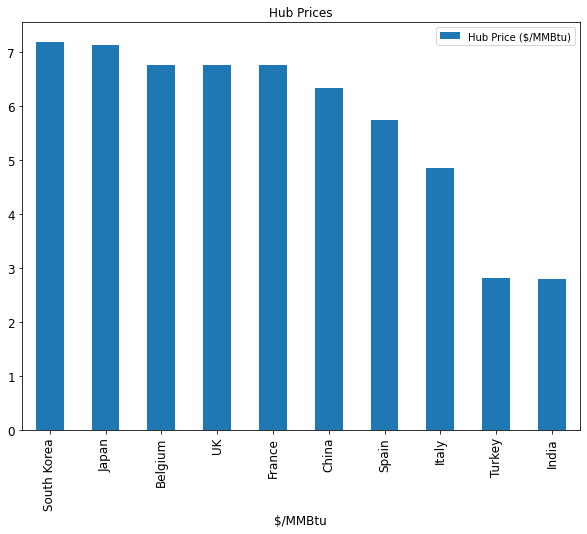

In [114]:
hp = Hub_Prices.T
hp.sort_values("Hub Price ($/MMBtu)", ascending=False, inplace = True)
ax = hp.plot(kind = 'bar', title = "Hub Prices", figsize = (10, 7.5), legend = True, fontsize = 12)
ax.set_xlabel("$/MMBtu", fontsize=12)
ax.set_ylabel("", fontsize=12)
plt.show()